In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA


# to be able to reproduce the same results on every run 
# let's already generate the random seed
np.random.seed(444)

%matplotlib inline


/Users/jean/miniconda3/envs/DS/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
def preprocess(data):
    X = data.copy()
    X.gender = X.gender.astype('category').cat.codes
    return X


# Run The PCA
def calculate_pca(n, data):
    pca = PCA(n_components = n)
    pca.fit(data)
    # Transform the instances using the PCA and store the result in a data frame
    return pd.DataFrame(pca.transform(data), columns = ['PCA%i' % i for i in range(n)], index = data.index)


def my_plot(points, title = None, fig=None, labels = None, colormap = "Set2_r"):
    # Plot initialisation
    sns.set_style("white")
    my_dpi=96

    fsize = (800/my_dpi, 600/my_dpi)
    if (fig == None):
        fig = plt.figure(figsize=fsize, dpi=my_dpi)

    ax = Axes3D(fig, rect = [0, 0, 1, 1], elev = 40, azim = 120)
    ax.scatter(points['PCA0'], points['PCA1'], points['PCA2'], 
               c = labels, cmap = colormap, s = 60)

    # make simple, bare axis lines through space:
    xAxisLine = ((min(points['PCA0']), max(points['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')

    yAxisLine = ((0, 0), (min(points['PCA1']), max(points['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')

    zAxisLine = ((0, 0), (0,0), (min(points['PCA2']), max(points['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(title)
    plt.show()   


# Experiments

## Projecting the input data in 3-dimensional space

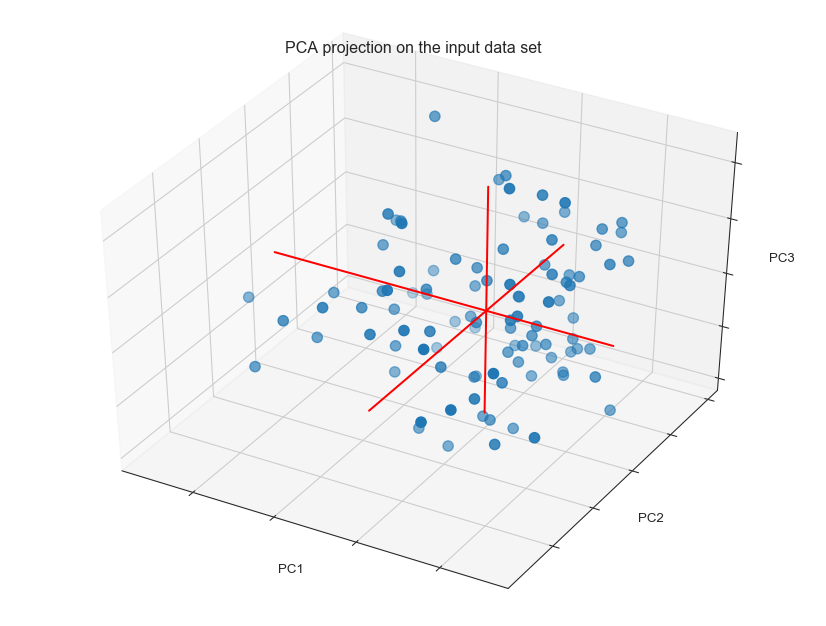

In [3]:
# load training data
dataset = pd.read_csv('customers.csv')
dataset.head()

# Transform gender attribute to numeric in order to calculate PCA
X = preprocess(dataset)

# Plot the input data projection (the ground truth)
projection = calculate_pca(3, X)
my_plot(projection, "PCA projection on the input data set")



## Create clustering models and choose the best one

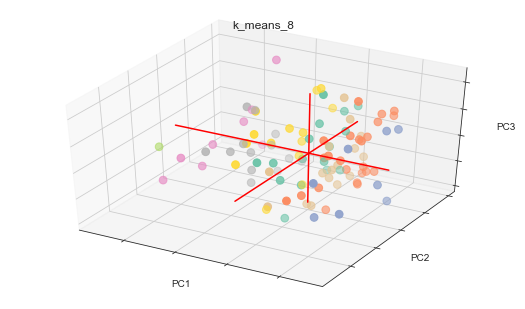

Estimator: k_means_8
Silhouette Coefficient: 0.221


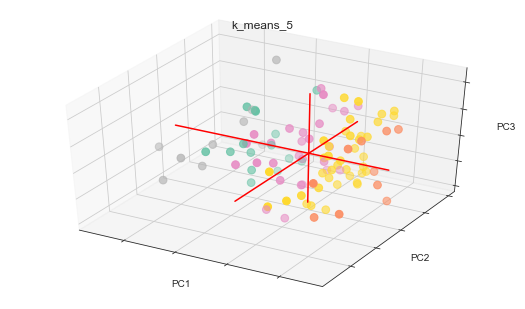

Estimator: k_means_5
Silhouette Coefficient: 0.301


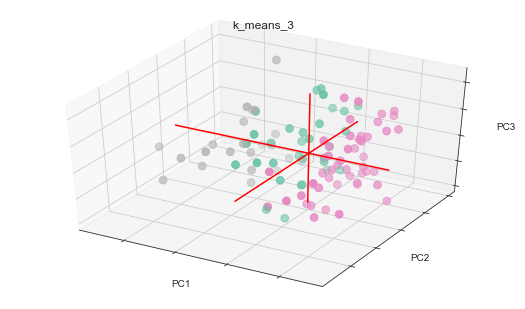

Estimator: k_means_3
Silhouette Coefficient: 0.422


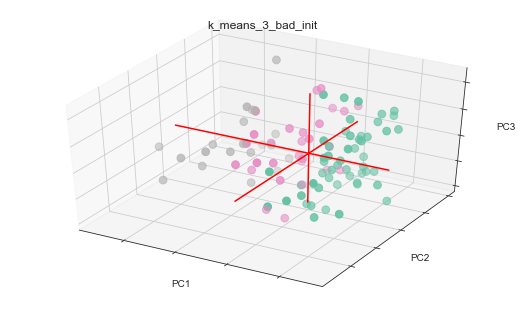

Estimator: k_means_3_bad_init
Silhouette Coefficient: 0.424


In [4]:
def evaluate_models(estimators, data):
    fignum = 1
    titles = ['5 clusters', '3 clusters', '3 clusters, bad initialization']
    for name, est in estimators:
        est.fit(X)
        labels = est.labels_
        fig = plt.figure(fignum, figsize = (7, 4))
        my_plot(data, name, fig, labels)
        print("Estimator: {}".format(name))
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels, sample_size=1000))
        fignum = fignum + 1
        
# create clustering models
estimators = [('k_means_8', KMeans(n_clusters=8, n_init = 30)),
    ('k_means_5', KMeans(n_clusters=5, n_init = 30)),
    ('k_means_3', KMeans(n_clusters=3, n_init = 30)),
    ('k_means_3_bad_init', KMeans(n_clusters=3, n_init=1, init='random'))]

evaluate_models(estimators, projection)

# Find the most appropriate tribe for a new customer

In [5]:
# Create a test dataset
test_df = preprocess(pd.read_csv('customer_test_data.csv'))

# Show the test instance
test_df.head()


,gender,age,numberOfChildren,mobility,aging,health,technology,fashion,house,food,leisure,sharing,energy
0,1,28.0,1.0,-1,-1,0,1,-1,1,-1,1,0,0
1,0,27.0,0.0,1,0,1,1,0,-1,0,0,0,-1
2,0,44.0,1.0,1,-1,0,0,-1,-1,1,0,0,1
3,1,51.0,1.0,0,1,1,-1,0,0,-1,1,0,-1


In [6]:
# Predict the cluster on the test dataset, using Kmean with k = 3, which is at the index 2 in our estimators array
_, estimator = estimators[2] 
prediction = estimator.predict(test_df)

# show the predicted cluster id for each test instance 
print(prediction)



[1 1 0 0]


In [7]:
# From the list of similar profiles (members of the same cluster)
# show some information about

def pears_stats(model, clusterID, dataset):
    similar_profiles = [idx for idx in range(0, len(model)-1) if model[idx] == clusterID]
    pears = dataset.iloc[similar_profiles]

    # Show mean, std, min value and max value of elements in the same cluster as test instance 0
    return pears, pears.describe().iloc[[1,2,3,7]]


In [8]:
model = estimator.labels_
_, stats = pears_stats(model, prediction[0], dataset)
print("Stats of cluster where test instance '{}' is".format(0))
stats

Stats of cluster where test instance '0' is


,age,numberOfChildren,mobility,aging,health,technology,fashion,house,food,leisure,sharing,energy
mean,26.148936,1.170213,0.382979,-0.063830,0.127660,0.595745,-0.021277,-0.148936,-0.148936,0.255319,0.042553,0.042553
std,2.851230,0.892460,0.848354,0.763409,0.679419,0.680779,0.793708,0.833503,0.779596,0.793125,0.750578,0.779003
min,18.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,30.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
pears, stats = pears_stats(model, prediction[2], dataset)
print("Stats of cluster where test instance '{}' is".format(2))
stats

Stats of cluster where test instance '2' is


,age,numberOfChildren,mobility,aging,health,technology,fashion,house,food,leisure,sharing,energy
mean,45.863636,1.272727,0.181818,-0.136364,0.045455,0.045455,0.000000,-0.181818,-0.136364,0.227273,-0.181818,0.136364
std,4.334748,0.935125,0.732664,0.774317,0.843873,0.722250,0.872872,0.795006,0.710161,0.685344,0.732664,0.888844
min,41.000000,-0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,59.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Check the stocks mostly invested by a given cluster

In [10]:
folios = pd.read_csv('portfolios.csv')
folios.head()

,BMW,HM-B,KIN,NFLX,TSLA,ECA,EQNR,FUR,FP,RIG,...,AKZA,NTR,REC,RES,UMI,ADBE,CTSH,FB,GOOGL,MSFT
0,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


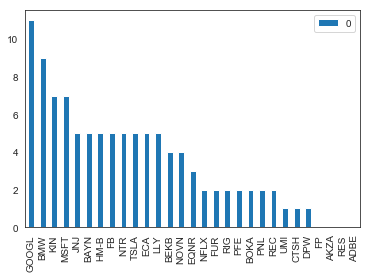

In [12]:
similar_profiles = pears.index
stocks = folios.loc[similar_profiles]
s = pd.DataFrame(stocks.sum(axis=0).sort_values(0, ascending=False))
s.plot.bar()